# Berlin Airbnb Exploratory Data Analysis

In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pathlib import Path

In [47]:
sns.set(style='whitegrid', palette='coolwarm')

## Project Brief

For this project we are interested in predicting the price a new airbnb user in Berlin should advertise their property for. We have 6 different tables that have been scraped from airbnb and put on kaggle. The 6 tables are:

- Calendar Summary
- Listings Summary
- Listings Detailed
- Neighbourhoods
- Reviews
- Reviews Detailed

As we are interested in predicting the price a new host should advertise their house for, the reviews data will most likely not be useful as this is retrospective data.

Firstly, I will explore the data sets and make notes of the data format and usefulness. Then I will clean the data to put in a useful format and perform some feature engineering to create useful information. Then I will attempt to create a model that accurately predicts the price of an airbnb in Berlin, given the property specifications.

In [48]:
# Read in all the tables
DATA_PATH = Path("../data/raw/")
calendar_summary = pd.read_csv(DATA_PATH/"calendar_summary.csv",parse_dates=["date"])
listings = pd.read_csv(DATA_PATH/"listings.csv", parse_dates=["last_review"])
listing_summary = pd.read_csv(
    DATA_PATH/"listings_summary.csv",
    parse_dates=[
        "last_scraped",
        "calendar_last_scraped",
        "last_review",
        "first_review",
        "host_since"
    ]
)
neighbourhoods = pd.read_csv(DATA_PATH/"neighbourhoods.csv")
reviews = pd.read_csv(DATA_PATH/"reviews.csv", parse_dates=["date"])
reviews_summary = pd.read_csv(DATA_PATH/"reviews_summary.csv", parse_dates=["date"])

# Describe the data

Calendar data for listings in Berlin

In [49]:
calendar_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8231480 entries, 0 to 8231479
Data columns (total 4 columns):
listing_id    int64
date          datetime64[ns]
available     object
price         object
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 251.2+ MB


Listing summary information for Berlin

In [50]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 16 columns):
id                                22552 non-null int64
name                              22493 non-null object
host_id                           22552 non-null int64
host_name                         22526 non-null object
neighbourhood_group               22552 non-null object
neighbourhood                     22552 non-null object
latitude                          22552 non-null float64
longitude                         22552 non-null float64
room_type                         22552 non-null object
price                             22552 non-null int64
minimum_nights                    22552 non-null int64
number_of_reviews                 22552 non-null int64
last_review                       18644 non-null datetime64[ns]
reviews_per_month                 18638 non-null float64
calculated_host_listings_count    22552 non-null int64
availability_365                  22552 non-nu

More detailed listing information for Berlin

In [51]:
listing_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
id                                  22552 non-null int64
listing_url                         22552 non-null object
scrape_id                           22552 non-null int64
last_scraped                        22552 non-null datetime64[ns]
name                                22493 non-null object
summary                             21589 non-null object
space                               14020 non-null object
description                         22349 non-null object
experiences_offered                 22552 non-null object
neighborhood_overview               11540 non-null object
notes                               7215 non-null object
transit                             13036 non-null object
access                              10837 non-null object
interaction                         10406 non-null object
house_rules                         11449 non-null object
thumbnail_url   

In [52]:
listings_detailed = listing_summary
listings_summary = listings

Berlin neighbourhood data

In [53]:
neighbourhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
neighbourhood_group    138 non-null object
neighbourhood          138 non-null object
dtypes: object(2)
memory usage: 2.3+ KB


Summary reviews for listings in Berlin

In [54]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401963 entries, 0 to 401962
Data columns (total 2 columns):
listing_id    401963 non-null int64
date          401963 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.1 MB


Detailed reviews information for listings in Berlin

In [55]:
reviews_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401963 entries, 0 to 401962
Data columns (total 6 columns):
listing_id       401963 non-null int64
id               401963 non-null int64
date             401963 non-null datetime64[ns]
reviewer_id      401963 non-null int64
reviewer_name    401963 non-null object
comments         401467 non-null object
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 18.4+ MB


In [56]:
reviews_detailed = reviews_summary
reviews_summary = reviews

### calendar_summary exploration

In [57]:
# Check for null values
calendar_summary.isnull().sum()

listing_id          0
date                0
available           0
price         6430639
dtype: int64

In [58]:
print(
    "Null values when available column is 'f': " + 
    str(calendar_summary[calendar_summary["available"]=="f"].isnull().sum()['price'])
)
print(
    "Null values when available column is not 'f': " + 
    str(calendar_summary[calendar_summary["available"]!="f"].isnull().sum()['price'])
)

Null values when available column is 'f': 6430639
Null values when available column is not 'f': 0


Summary information for datetime

In [59]:
calendar_summary.describe(include='datetime').T

,count,unique,top,freq,first,last
date,8231480,367,2019-02-10,22552,2018-11-07,2019-11-08


Summary information for object

In [60]:
calendar_summary.describe(include='object').T

,count,unique,top,freq
available,8231480,2,f,6430639
price,1800841,684,$50.00,68088


Percentage of price column that has missing values

In [61]:
print(100 * calendar_summary['price'].isnull().sum() /  len(calendar_summary))

78.12251259797752


### listings exploration

First I will determine if the summary data contains anything the detailed data doesn't

In [62]:
set(listings_summary.columns) - set(listings_detailed.columns)

{'neighbourhood_group'}

In [63]:
listings_summary['neighbourhood_group'].describe()

count                        22552
unique                          12
top       Friedrichshain-Kreuzberg
freq                          5497
Name: neighbourhood_group, dtype: object

In [64]:
listings_detailed['neighbourhood_group_cleansed'].describe()

count                        22552
unique                          12
top       Friedrichshain-Kreuzberg
freq                          5497
Name: neighbourhood_group_cleansed, dtype: object

In [65]:
all(listings_summary['neighbourhood_group'] == listings_detailed['neighbourhood_group_cleansed'])

True

In [66]:
wanted_columns = set(listings_summary.columns) - {"neighbourhood_group"}
all(listing_summary[wanted_columns] == listings_detailed[wanted_columns])

True

listings_summary is a less detailed version with duplicate results so we can just use the detailed version

In [67]:
listings_df = listings_detailed
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Percentage of missing values in each column with a missing value

In [68]:
100 * (listings_df.isnull().sum()[(listings_df.isnull().sum() > 0)] / len(listings_df)).sort_values(ascending=False)

medium_url                     100.000000
jurisdiction_names             100.000000
thumbnail_url                  100.000000
host_acceptance_rate           100.000000
xl_picture_url                 100.000000
square_feet                     98.022348
license                         92.736786
monthly_price                   88.209471
weekly_price                    83.677723
notes                           68.007272
host_response_rate              57.178964
host_response_time              57.174530
interaction                     53.857751
access                          51.946612
host_about                      50.385775
house_rules                     49.232884
neighborhood_overview           48.829372
transit                         42.195814
security_deposit                41.508514
space                           37.832565
cleaning_fee                    31.686768
host_neighbourhood              22.587797
review_scores_value             19.665662
review_scores_checkin           19

Summary of the numerical data

In [69]:
listings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,22552.0,1.571560e+07,8.552069e+06,2.015000e+03,8.065954e+06,1.686638e+07,2.258393e+07,2.986735e+07
scrape_id,22552.0,2.018111e+13,0.000000e+00,2.018111e+13,2.018111e+13,2.018111e+13,2.018111e+13,2.018111e+13
thumbnail_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
medium_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xl_picture_url,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,22552.0,5.403355e+07,5.816290e+07,2.217000e+03,9.240002e+06,3.126711e+07,8.067518e+07,2.245081e+08
host_acceptance_rate,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_listings_count,22526.0,2.330685e+00,1.994782e+01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.676000e+03
host_total_listings_count,22526.0,2.330685e+00,1.994782e+01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.676000e+03
latitude,22552.0,5.250982e+01,3.082546e-02,5.234580e+01,5.248906e+01,5.250908e+01,5.253267e+01,5.265167e+01


Summary of the object data

In [70]:
listings_df.describe(include='object').T

,count,unique,top,freq
listing_url,22552,22552,https://www.airbnb.com/rooms/14226270,1
name,22493,21873,Berlin Wohnung,14
summary,21589,21041,"with en-suite bathroom, TV, WIFI, bed linen, a...",14
space,14020,13598,The Singer 109 Hostel is located in the heart ...,41
description,22349,21997,We are located in one of the most colorful dis...,12
experiences_offered,22552,1,none,22552
neighborhood_overview,11540,10781,Welcome Traveler. The Singer Hostel and Apart...,43
notes,7215,6687,Since 01.01.2014 the city of Berlin had to ado...,37
transit,13036,12308,U-Bahn / Underground /Subway / Metro: U5 (Stra...,26
access,10837,9946,We can offer our guests - Pool table/Snooker -...,42


Summary information datetime information

In [71]:
listings_df.describe(include="datetime").T

,count,unique,top,freq,first,last
last_scraped,22552,2,2018-11-07,22549,2018-11-07,2018-11-09
host_since,22526,2914,2017-02-20,51,2008-08-18,2018-11-06
calendar_last_scraped,22552,2,2018-11-07,22549,2018-11-07,2018-11-09
first_review,18638,2228,2017-05-28,116,2009-06-20,2018-11-07
last_review,18644,1312,2018-11-04,618,2010-09-16,2018-11-07


Change t and f columns to boolean values and give summary

In [72]:
"""
boolean_conversion = {"t": True, "f": False}
boolean_columns = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "is_location_exact",
    "has_availability",
    "requires_license",
    "instant_bookable",
    "is_business_travel_ready",
    "require_guest_profile_picture",
    "require_guest_phone_verification"
]
for boolean_column in boolean_columns:
    listings_df[boolean_column] = listings_df[boolean_column].map(boolean_conversion)
"""

'\nboolean_conversion = {"t": True, "f": False}\nboolean_columns = [\n    "host_is_superhost",\n    "host_has_profile_pic",\n    "host_identity_verified",\n    "is_location_exact",\n    "has_availability",\n    "requires_license",\n    "instant_bookable",\n    "is_business_travel_ready",\n    "require_guest_profile_picture",\n    "require_guest_phone_verification"\n]\nfor boolean_column in boolean_columns:\n    listings_df[boolean_column] = listings_df[boolean_column].map(boolean_conversion)\n'

Analysing the distribution by neighbourhood

Text(0.5, 1.0, 'Distribution by Neighbourhood')

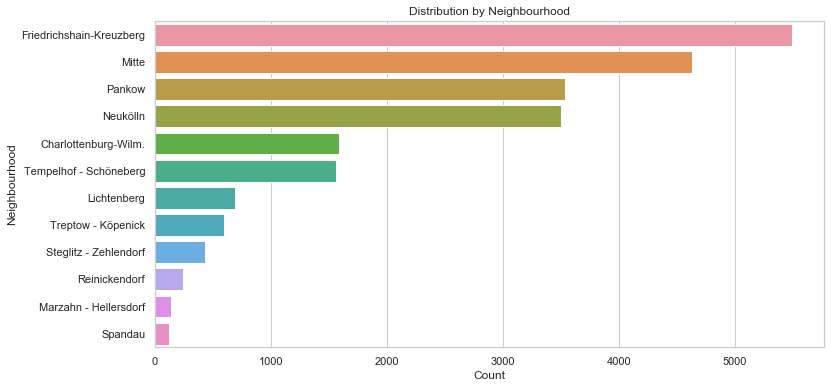

In [73]:
listings_by_neighbourhood = listings_df.groupby("neighbourhood_group_cleansed").count()["id"].sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=listings_by_neighbourhood.values,y=listings_by_neighbourhood.index)
plt.xlabel("Count")
plt.ylabel("Neighbourhood")
plt.title("Distribution by Neighbourhood")

Convert the price to a float

In [74]:
def price_string_to_float(price):
    """
    converts price string from string to float
    """
    return float(price.replace(",","").replace("$",""))

In [75]:
currency_columns = [
    'price',
    'weekly_price',
    'monthly_price',
    'security_deposit',
    'cleaning_fee',
    'extra_people'
]
for currency_column in currency_columns:
    listings_df[currency_column] = listings_df[currency_column].apply(lambda x: price_string_to_float(x) if pd.notnull(x) else x)

Analysing the distribution by room type

In [76]:
listings_df.groupby("room_type").describe().price

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,10722.0,83.348909,141.323687,0.0,49.0,65.0,91.0,9000.0
Private room,11534.0,52.479105,271.403759,0.0,25.0,35.0,45.0,8600.0
Shared room,296.0,51.564189,291.685951,8.0,18.0,25.0,38.0,5000.0


Text(0.5, 1.0, 'Distribution by Room Type')

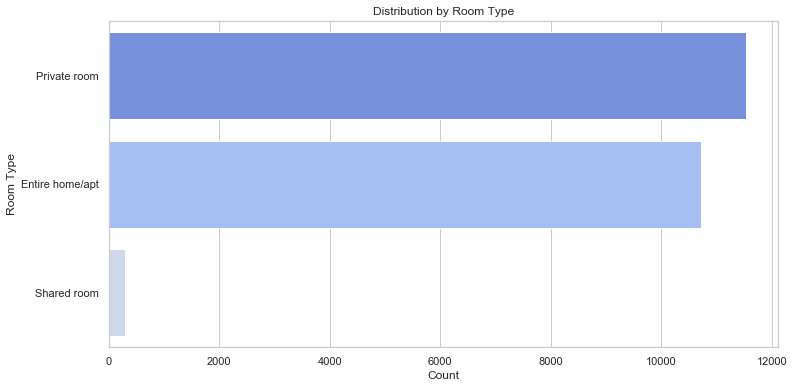

In [77]:
listings_by_room_type = listings_df.groupby("room_type").count()["id"].sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=listings_by_room_type.values,y=listings_by_room_type.index)
plt.xlabel("Count")
plt.ylabel("Room Type")
plt.title("Distribution by Room Type")

Set the index to be the listing id

In [78]:
listings_df = listings_df.set_index("id")

Checking the data for duplicates

In [79]:
all(~listings_df.duplicated())

True

Analysing the distribution of the price

Text(0.5, 1.0, 'Price Distribution')

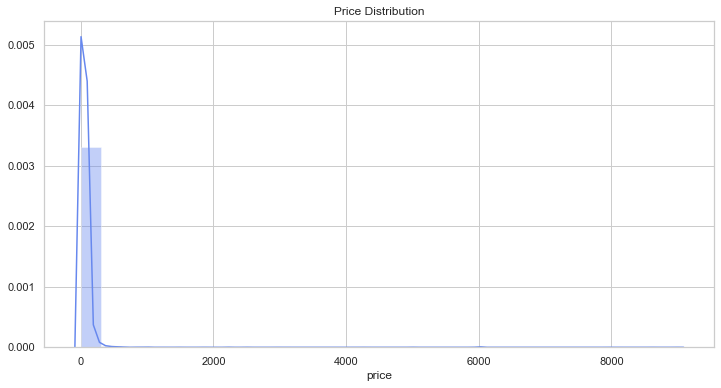

In [80]:
plt.figure(figsize=(12,6))
sns.distplot(listings_df["price"], bins=30)
plt.title("Price Distribution")

Exploring the distribution of accomodations by number of bedrooms

In [81]:
listings_by_bedroom_no = listings_df.groupby("bedrooms").describe()["price"]
listings_by_bedroom_no

,count,mean,std,min,25%,50%,75%,max
bedrooms,,,,,,,,
0.0,1477.0,55.974272,71.595328,10.0,35.00,50.0,65.00,2500.0
1.0,17164.0,57.933524,237.000776,0.0,30.00,40.0,60.00,9000.0
2.0,2973.0,93.670703,77.045447,0.0,55.00,80.0,110.00,1900.0
3.0,723.0,147.319502,163.514310,9.0,80.00,119.0,171.00,3000.0
4.0,143.0,175.692308,109.218945,22.0,100.00,150.0,220.00,650.0
5.0,34.0,571.941176,1377.128808,69.0,171.25,242.5,356.75,8000.0
6.0,10.0,262.200000,147.309048,70.0,152.25,257.0,360.00,500.0
7.0,3.0,346.333333,232.379718,79.0,269.50,460.0,480.00,500.0
8.0,4.0,408.000000,352.269783,74.0,220.25,329.5,517.25,899.0


Text(0, 0.5, 'Count')

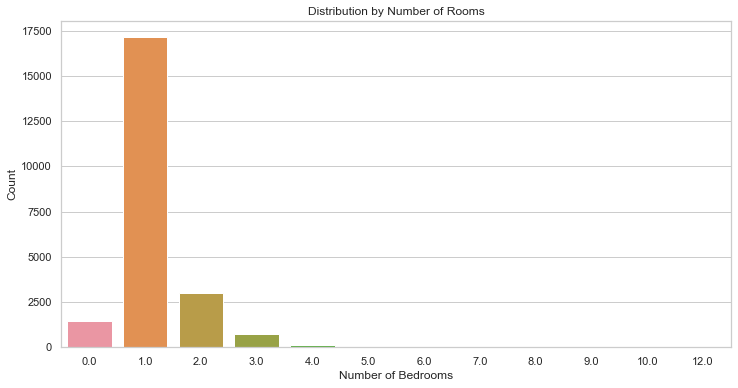

In [82]:
plt.figure(figsize=(12,6))
sns.barplot(x=listings_by_bedroom_no.index, y=listings_by_bedroom_no["count"])
plt.title("Distribution by Number of Rooms")
plt.xlabel("Number of Bedrooms")
plt.ylabel("Count")

Analysing the host data

In [90]:
host_columns = [column for column in listings_df.columns if "host" in column]
listings_df[host_columns].isnull().sum()

host_id                               0
host_url                              0
host_name                            26
host_since                           26
host_location                       116
host_about                        11363
host_response_time                12894
host_response_rate                12895
host_acceptance_rate              22552
host_is_superhost                    26
host_thumbnail_url                   26
host_picture_url                     26
host_neighbourhood                 5094
host_listings_count                  26
host_total_listings_count            26
host_verifications                    0
host_has_profile_pic                 26
host_identity_verified               26
calculated_host_listings_count        0
dtype: int64

## Neighbourhoods exploration

In [83]:
neighbourhoods.describe()

,neighbourhood_group,neighbourhood
count,138,138
unique,12,138
top,Treptow - Köpenick,Moabit West
freq,20,1


In [84]:
neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,Charlottenburg-Wilm.,Barstraße
1,Charlottenburg-Wilm.,Charlottenburg Nord
2,Charlottenburg-Wilm.,Düsseldorfer Straße
3,Charlottenburg-Wilm.,Forst Grunewald
4,Charlottenburg-Wilm.,Grunewald


Barplot representing the number of neighbourhoods that constitute to a neighbourhood group

Text(0.5, 0, 'Neighbourhoods')

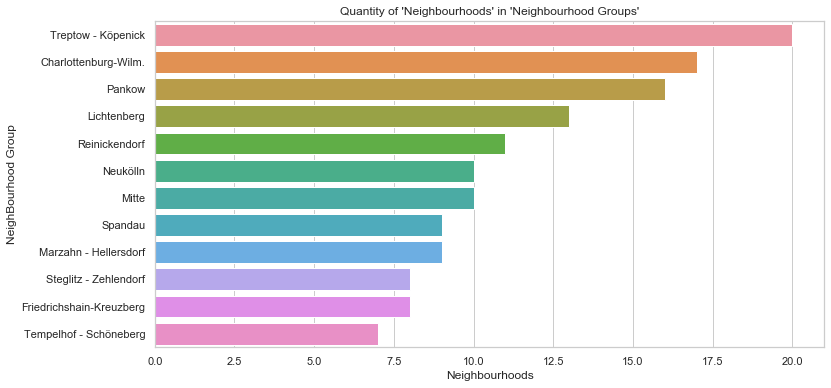

In [85]:
neighbourhood_groups_count = neighbourhoods.groupby("neighbourhood_group").count()["neighbourhood"].sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=neighbourhood_groups_count.values, y=neighbourhood_groups_count.index)
plt.title("Quantity of 'Neighbourhoods' in 'Neighbourhood Groups'")
plt.ylabel("NeighBourhood Group")
plt.xlabel("Neighbourhoods")

## Exploration Review

1. Calendar Summary

  - The only missing values are in the price column.
  - Price is only missing when available is 'f'.
  - The entries are from the period of 7/11/2018 to 8/11/2019
  - Could this be used to analyse how prices/availability fluctuate depending on time of year/day of the week?
  
  
2. Listings

  - There are five columns with entirely empty columns and many missing the majority of entries.
  - Nearly 20% of the listings dont have any review data.
  - There are a small amount of rows missing (seemingly) important information (beds, etc.).
  - All the hosts have been registered between 18/8/2008 and 6/11/2018.
  - There are 26 hosts that are missing most/all information about themselves.
  
  
3. Neighbourhoods

  - There are 12 neighbourhood groups that contain 138 neighbourhoods in total.
  
  
  
I will mostly use the listings data to create a model to predict the price. However, I will also attempt to use the calender data to model the change in price in different times of the year/days of the week.

## Data Cleaning

Remove columns that contain no information or zero variance

In [97]:
columns_to_remove = [
    "medium_url",
    "jurisdiction_names",
    "thumbnail_url",
    "host_acceptance_rate",
    "xl_picture_url",
    "experiences_offered",
    "country",
    "country_code",
    "has_availability",
    "is_business_travel_ready"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

Remove descriptive columns

In [100]:
columns_to_remove = [
    "listing_url",
    "name",
    "summary",
    "space",
    "description",
    "neighborhood_overview",
    "notes",
    "transit",
    "access",
    "interaction",
    "house_rules",
    "picture_url",
    "host_url",
    "host_name",
    "host_location",
    "host_about",
    "host_response_rate",
    "host_thumbnail_url",
    "host_picture_url",
    "license"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

Remove scrape data

In [103]:
listings_df.drop(['scrape_id', 'last_scraped'], axis=1, inplace=True)

Remove columns with a large amount of missing data

In [106]:
columns_to_remove = [
    "square_feet",
    "monthly_price",
    "weekly_price",
    "host_response_time",
    "security_deposit",
    "cleaning_fee",
    "host_neighbourhood",
    "first_review",
    "last_review"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

Now I will get rid of a number of columns that a new host to airbnb wouldn't be able to provide or wouldn't be applicable

In [118]:
columns_to_remove = [
    "host_id",
    "host_since",
    "host_has_profile_pic",
    "calendar_updated",
    "calendar_last_scraped",
    "number_of_reviews",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value"
]
listings_df.drop(columns_to_remove, axis=1, inplace=True)

In [122]:
listings_df.describe(include='object')

,host_is_superhost,host_verifications,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,...,is_location_exact,property_type,room_type,bed_type,amenities,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,22526,22552,22526,22552,21421,22552,22552,22547,22468,21896,...,22552,22552,22552,22552,22552,22552,22552,22552,22552,22552
unique,2,301,2,86,91,136,12,60,19,215,...,2,33,3,5,19985,2,2,5,2,2
top,f,"['email', 'phone', 'reviews']",f,"Berlin, Berlin, Germany",Neukölln,Tempelhofer Vorstadt,Friedrichshain-Kreuzberg,Berlin,Berlin,10245,...,t,Apartment,Private room,Real Bed,{},t,f,flexible,f,f
freq,19515,4103,13824,22317,3209,1325,5497,22417,22417,855,...,16776,20225,11534,21766,75,22544,15518,9102,22396,22273


Convert binary classification columns to boolean

In [133]:
bool_columns = [
    "is_location_exact",
    "requires_license",
    "instant_bookable",
    "require_guest_profile_picture",
    "require_guest_phone_verification"
]
for bool_column in bool_columns:
    listings_df[bool_column].map({"t": True, "f": False})

We have many outliers in the price column that will make modelling difficult, 